# Hoja de trabajo 06
#### Jose Daniel Gomez Cabrera 21429
#### Carlos Daniel Estrada 20853

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sb
from sklearn.compose import make_column_selector as selector
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
import statsmodels.api as sm
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import RidgeClassifier

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 9)
plt.style.use('ggplot')

In [2]:
houses = pd.read_csv('train.csv')
houses.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


1. Cree una variable <strong>dicotómica</strong> por cada una de las categorías de la variable respuesta categórica que creó en hojas anteriores. Debería tener 3 variables dicotómicas (valores 0 y 1) una que diga si la vivienda es cara o no, media o no, económica o no.

In [3]:
houses = pd.read_csv('train.csv')

# Define categories
categories = ['Economic', 'Intermediate', 'Expensive']

# Create a new column with the categories
houses['PriceCategory'] = pd.qcut(houses['SalePrice'], q=len(categories), labels=categories)
houses['PriceCategory'] = houses['PriceCategory'].astype('category')

# Create dummy variables
dummies = pd.get_dummies(houses['PriceCategory'])

# Join the dummy variables to the main dataframe
houses = pd.concat([houses, dummies], axis=1)

# Now you have three dichotomous variables: 'Economic', 'Intermediate', and 'Expensive'
print(houses[['Economic', 'Intermediate', 'Expensive']])

      Economic  Intermediate  Expensive
0        False         False       True
1        False          True      False
2        False         False       True
3        False          True      False
4        False         False       True
...        ...           ...        ...
1455     False          True      False
1456     False         False       True
1457     False         False       True
1458     False          True      False
1459     False          True      False

[1460 rows x 3 columns]


2. Use los mismos conjuntos de entrenamiento y prueba que utilizó en las hojas anteriores.

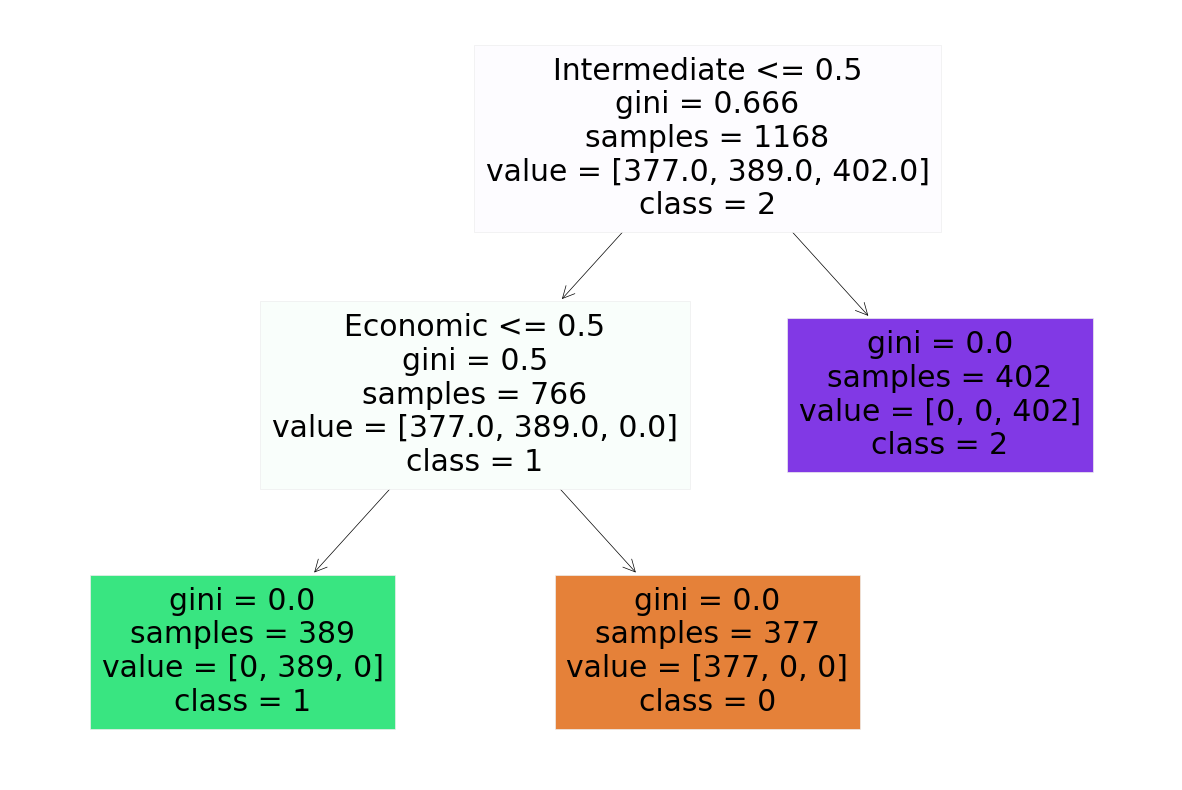

In [4]:
y = houses.copy().pop('PriceCategory')
X = houses

# Convertir las variables categóricas a forma numerica
X_dummy = pd.get_dummies(X)

# Dividir tus datos y entrenar modelo
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y, test_size=0.2,  random_state=42)

# Instanciar el arbol y su profundidad
clf = DecisionTreeClassifier(max_depth=6, random_state=42)
# Entrenar arbol de acuerdo a los datos de entrenamiento
clf.fit(X_train, y_train)

# Graficar arbol de clasificacion
plt.figure(figsize=(15, 10))
tree.plot_tree(clf, feature_names=X_dummy.columns, class_names=['0','1','2'], filled=True)
plt.show()

Confussion matrix: 
[[110   0   0]
 [  0  94   0]
 [  0   0  88]]

Accuracy: 1.0
Precision: [1. 1. 1.]
Recall: [1. 1. 1.]
F1 score: [1. 1. 1.]


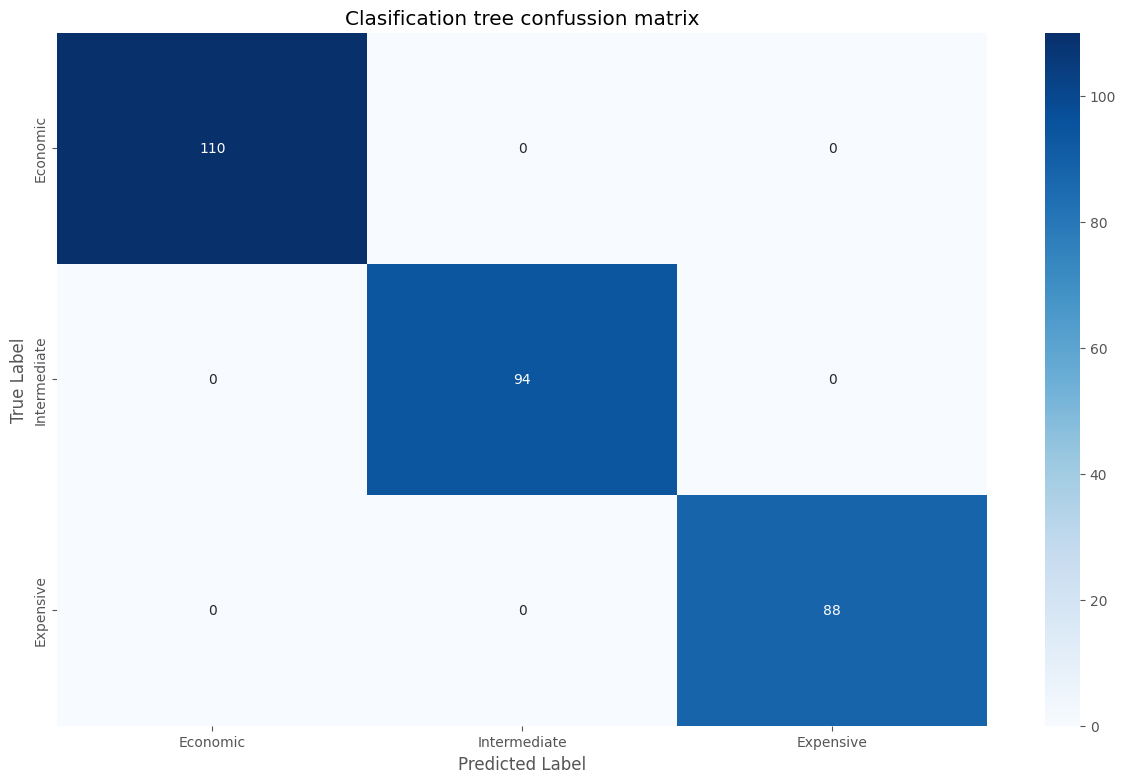

In [5]:
# Predecir etiquetas para los datos de prueba
y_pred = clf.predict(X_test)

# Instanciar matriz de confusión
confussionMatrix = confusion_matrix(y_test, y_pred)

# Calcular metricas de evaluacion de la matriz de confusion
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Mostrar resultados
print(f"Confussion matrix: \n{confussionMatrix}\n")
print(f"Accuracy: {format(accuracy)}")
print(f"Precision: {format(precision)}")
print(f"Recall: {format(recall)}")
print(f"F1 score: {format(f1)}")

# Visualizar la matriz de confusión
sb.heatmap(
  confussionMatrix,
  annot=True,
  cmap="Blues",
  fmt="d",
  xticklabels=['Economic', 'Intermediate', 'Expensive'],
  yticklabels=['Economic', 'Intermediate', 'Expensive']
)
plt.title('Clasification tree confussion matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

##### Validación cruzada

In [6]:
random.seed(123)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42)

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(houses)
categorical_columns = categorical_columns_selector(houses)

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns)])

param_grid = {"max_depth": np.arange(2, 10, 1)}
pipeline = Pipeline(
    [('preprocessor',preprocessor),
    ('regressor',DecisionTreeClassifier())])
params = [{
    "regressor__max_depth": np.arange(2, 10, 1)
}]
crossoverModel = GridSearchCV(pipeline, param_grid=params, n_jobs=2, cv=5,scoring="neg_root_mean_squared_error")
crossoverModel.fit(X_train,y_train)
crossoverModel.best_params_

crossoverModel_pred = crossoverModel.predict(X_test)
print("Crossover model")

# crossoverModel_pred
for i in range(0, len(crossoverModel_pred)):
    print(f"Predicted: {crossoverModel_pred[i]}, Real: {y_test.iloc[i]}")

Crossover model
Predicted: Economic, Real: Intermediate
Predicted: Expensive, Real: Expensive
Predicted: Intermediate, Real: Economic
Predicted: Intermediate, Real: Intermediate
Predicted: Expensive, Real: Expensive
Predicted: Economic, Real: Economic
Predicted: Expensive, Real: Expensive
Predicted: Intermediate, Real: Intermediate
Predicted: Economic, Real: Economic
Predicted: Economic, Real: Economic
Predicted: Intermediate, Real: Intermediate
Predicted: Economic, Real: Economic
Predicted: Expensive, Real: Economic
Predicted: Expensive, Real: Expensive
Predicted: Intermediate, Real: Intermediate
Predicted: Economic, Real: Economic
Predicted: Expensive, Real: Intermediate
Predicted: Economic, Real: Economic
Predicted: Intermediate, Real: Economic
Predicted: Expensive, Real: Expensive
Predicted: Intermediate, Real: Intermediate
Predicted: Expensive, Real: Expensive
Predicted: Expensive, Real: Intermediate
Predicted: Economic, Real: Economic
Predicted: Expensive, Real: Expensive
Predict

c:\Users\halm9\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Confussion matrix: 
[[84  5 21]
 [ 2 82 10]
 [25 26 37]]

Accuracy: 0.6952054794520548
Precision: [0.75675676 0.72566372 0.54411765]
Recall: [0.76363636 0.87234043 0.42045455]
F1 score: [0.760181   0.79227053 0.47435897]


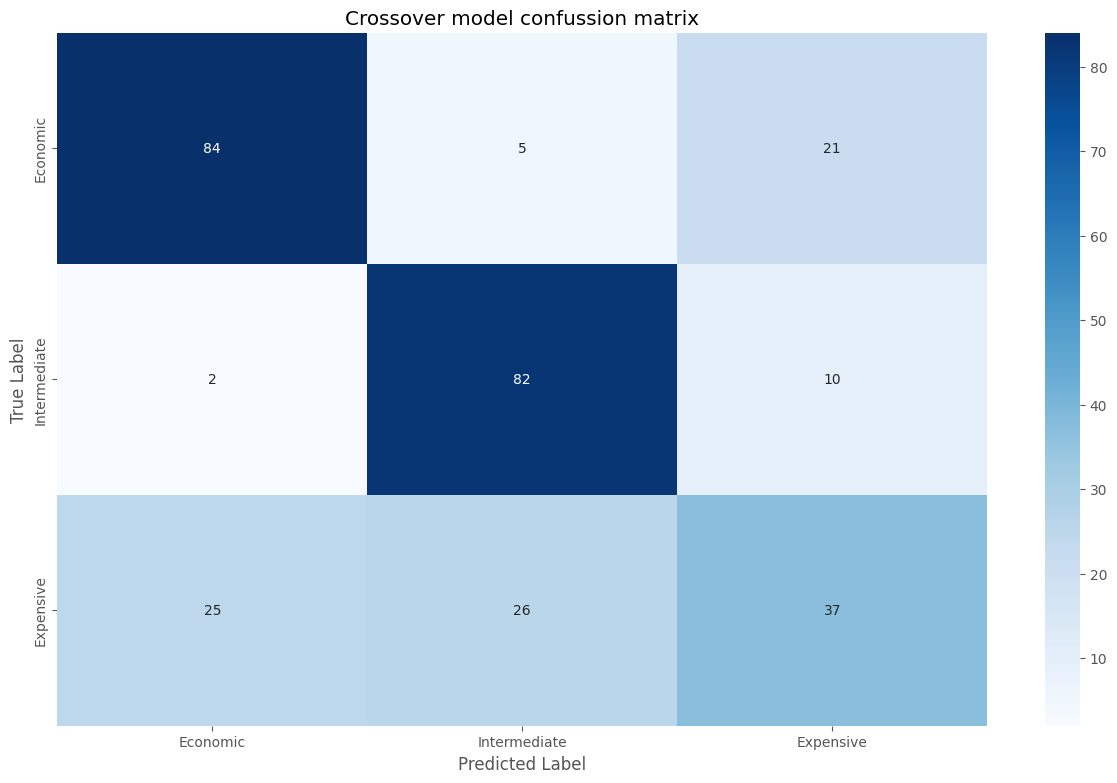

In [7]:
# Predecir etiquetas para los datos de prueba
crossoverModel_pred = crossoverModel.predict(X_test)

# Instanciar matriz de confusión
confussionMatrix = confusion_matrix(y_test, crossoverModel_pred)

# Calcular metricas de evaluacion de la matriz de confusion
accuracy = accuracy_score(y_test, crossoverModel_pred)
precision = precision_score(y_test, crossoverModel_pred, average=None)
recall = recall_score(y_test, crossoverModel_pred, average=None)
f1 = f1_score(y_test, crossoverModel_pred, average=None)

# Mostrar resultados
print(f"Confussion matrix: \n{confussionMatrix}\n")
print(f"Accuracy: {format(accuracy)}")
print(f"Precision: {format(precision)}")
print(f"Recall: {format(recall)}")
print(f"F1 score: {format(f1)}")

# Visualizar la matriz de confusión
sb.heatmap(
  confussionMatrix,
  annot=True,
  cmap="Blues",
  fmt="d",
  xticklabels=['Economic', 'Intermediate', 'Expensive'],
  yticklabels=['Economic', 'Intermediate', 'Expensive']
)
plt.title('Crossover model confussion matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

3. Elabore un modelo de regresión logística para conocer si una vivienda es cara o no, utilizando el conjunto de entrenamiento y explique los resultados a los que llega. El experimento debe ser reproducible por lo que debe fijar que los conjuntos de entrenamiento y prueba sean los mismos siempre que se ejecute el código. Use validación cruzada.

Quitar del conjunto de datos aquellas variables que no se aportan información relevante para la elaboración de modelos como el id, nombre, etc.

In [2]:
houses = pd.read_csv('train.csv')

# Define categories
categories = ['Economic', 'Intermediate', 'Expensive']

# Create a new column with the categories
houses['PriceCategory'] = pd.qcut(houses['SalePrice'], q=len(categories), labels=categories)
houses['PriceCategory'] = houses['PriceCategory'].astype('category')

# Create dummy variables
dummies = pd.get_dummies(houses['PriceCategory'])

# Join the dummy variables to the main dataframe
houses = pd.concat([houses, dummies], axis=1)

# Now you have three dichotomous variables: 'Economic', 'Intermediate', and 'Expensive'
print(houses[['Economic', 'Intermediate', 'Expensive']])

      Economic  Intermediate  Expensive
0        False         False       True
1        False          True      False
2        False         False       True
3        False          True      False
4        False         False       True
...        ...           ...        ...
1455     False          True      False
1456     False         False       True
1457     False         False       True
1458     False          True      False
1459     False          True      False

[1460 rows x 3 columns]


In [9]:
houses.drop(columns=["Id"],axis=1, inplace=True)
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 84 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     1460 non-null   int64   
 1   MSZoning       1460 non-null   object  
 2   LotFrontage    1201 non-null   float64 
 3   LotArea        1460 non-null   int64   
 4   Street         1460 non-null   object  
 5   Alley          91 non-null     object  
 6   LotShape       1460 non-null   object  
 7   LandContour    1460 non-null   object  
 8   Utilities      1460 non-null   object  
 9   LotConfig      1460 non-null   object  
 10  LandSlope      1460 non-null   object  
 11  Neighborhood   1460 non-null   object  
 12  Condition1     1460 non-null   object  
 13  Condition2     1460 non-null   object  
 14  BldgType       1460 non-null   object  
 15  HouseStyle     1460 non-null   object  
 16  OverallQual    1460 non-null   int64   
 17  OverallCond    1460 non-null   in

- Alley no posee 94.8 % de sus datos, entonces la vamos a eliminar
- Pero LotFrontage solo le falta el 17.7 % entonces la llenaremos con la media

In [10]:
houses.drop(columns=["Alley"],axis=1, inplace=True)
houses["LotFrontage"].fillna(np.nanmedian(houses["LotFrontage"],), inplace=True)
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 83 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     1460 non-null   int64   
 1   MSZoning       1460 non-null   object  
 2   LotFrontage    1460 non-null   float64 
 3   LotArea        1460 non-null   int64   
 4   Street         1460 non-null   object  
 5   LotShape       1460 non-null   object  
 6   LandContour    1460 non-null   object  
 7   Utilities      1460 non-null   object  
 8   LotConfig      1460 non-null   object  
 9   LandSlope      1460 non-null   object  
 10  Neighborhood   1460 non-null   object  
 11  Condition1     1460 non-null   object  
 12  Condition2     1460 non-null   object  
 13  BldgType       1460 non-null   object  
 14  HouseStyle     1460 non-null   object  
 15  OverallQual    1460 non-null   int64   
 16  OverallCond    1460 non-null   int64   
 17  YearBuilt      1460 non-null   in

C:\Users\halm9\AppData\Local\Temp\ipykernel_19928\3745615184.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  houses["LotFrontage"].fillna(np.nanmedian(houses["LotFrontage"],), inplace=True)


In [124]:
housesTypes = houses.dtypes
housesTypes

MSSubClass          int64
MSZoning           object
LotFrontage       float64
LotArea             int64
Street             object
                   ...   
SalePrice           int64
PriceCategory    category
Economic             bool
Intermediate         bool
Expensive            bool
Length: 83, dtype: object

¿Cuantas variables categoricas hay?

In [11]:
categoricals = {}

# store all int64 or float64 dtypes series in a dictionary
for column, dtype in houses.dtypes.items():
  if dtype == "category":
    categoricals[column] = str(dtype)

categoricals

{'PriceCategory': 'category'}

Codificamos la variable categorica

In [12]:
houses[["PriceCategoryNum"]]=houses[['PriceCategory']].apply(lambda x: pd.factorize(x)[0])

Seleccionar variables numericas para el modelo

In [5]:
numerics = []

# store all int64 or float64 dtypes series in a dictionary
for column, dtype in houses.dtypes.items():
  if (dtype == "int64" or dtype == "float64" or dtype == "uint8") and houses[column].isnull().sum() == 0:
    numerics.append(column)

numerics

['Id',
 'MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

Muestreo aleatorio simple para nuestra variable objetivo: Expensive

In [6]:
y = houses.pop("Expensive")
X = houses

# List of all columns
all_columns = X.columns.tolist()

# Columns to drop
columns_to_drop = [col for col in all_columns if col not in numerics]

X.drop(columns_to_drop, axis=1, inplace=True)
X_train, X_test,y_train, y_test = train_test_split(X, y,test_size=0.3,train_size=0.7)

KeyError: 'Expensive'

In [7]:
y.value_counts()

Expensive
False    977
True     483
Name: count, dtype: int64

##### Modelo de regresion logistica

In [8]:
numerics.remove("Expensive")
logReg = LogisticRegression(solver='liblinear')
result = logReg.fit(X_train[numerics],y_train)

ValueError: list.remove(x): x not in list

In [ ]:
y_pred = logReg.predict(X_test[numerics])
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logReg.score(X_test[numerics], y_test)))

NameError: name 'logReg' is not defined

In [ ]:
print(classification_report(y_test,y_pred))

logit_roc_auc = roc_auc_score(y_test, logReg.predict(X_test[numerics]))
fpr, tpr, thresholds = roc_curve(y_test, logReg.predict_proba(X_test[numerics])[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Regresión Logística (area = %0.2f)' % logit_roc_auc, color="steelblue")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [438, 292]

Modelo de validacion cruzada

In [ ]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=logReg, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

# Encode categorical variables
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(X)

# Fit the logistic regression model with the encoded data
grid_result = grid_search.fit(X_encoded, y)

NameError: name 'logReg' is not defined

In [16]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
model = RidgeClassifier()
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# define grid search
grid = dict(alpha=alpha)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.997489 using {'alpha': 0.1}
0.997489 (0.004503) with: {'alpha': 0.1}
0.997489 (0.004503) with: {'alpha': 0.2}
0.997489 (0.004503) with: {'alpha': 0.3}
0.997489 (0.004503) with: {'alpha': 0.4}
0.997489 (0.004503) with: {'alpha': 0.5}
0.997489 (0.004503) with: {'alpha': 0.6}
0.997489 (0.004503) with: {'alpha': 0.7}
0.997489 (0.004503) with: {'alpha': 0.8}
0.997489 (0.004503) with: {'alpha': 0.9}
0.997489 (0.004503) with: {'alpha': 1.0}


In [ ]:
ypred = grid_search.predict(X_test)
print(classification_report(y_test,y_pred))

logit_roc_auc = roc_auc_score(y_test, logReg.predict(X_test[numerics]))
fpr, tpr, thresholds = roc_curve(y_test, logReg.predict_proba(X_test[numerics])[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Regresión Logística (area = %0.2f)' % logit_roc_auc, color="steelblue")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [438, 292]

7. Haga un tuneo del modelo para determinar los mejores parámetros, recuerde que los modelos de regresión logística se pueden regularizar como los de regresión lineal.


In [4]:
# Define los hiperparámetros que deseas ajustar
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Parámetro de regularización
    'penalty': ['l1', 'l2']  # Tipo de regularización
}

# Instancia el modelo de regresión logística
logistic_regression = LogisticRegression(solver='liblinear')

# Utiliza GridSearchCV para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Muestra los mejores parámetros encontrados
print("Mejores parámetros:", grid_search.best_params_)

# Evalúa el modelo con los mejores parámetros en los datos de prueba
y_pred = grid_search.predict(X_test)
print("Informe de clasificación:")
print(classification_report(y_test, y_pred))


NameError: name 'LogisticRegression' is not defined

8. Haga un análisis de la eficiencia del algoritmo usando una matriz de confusión. Tenga en cuenta la efectividad, donde el algoritmo se equivocó más, donde se equivocó menos y la importancia que tienen los errores, el tiempo y la memoria consumida. Para esto último puede usar “profvis” si trabaja con R y “cProfile” en Python.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sb
import matplotlib.pyplot as plt
import cProfile

houses = pd.read_csv('train.csv')
y = houses.copy().pop('PriceCategory')
X = houses
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(max_depth=6, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

sb.heatmap(
  conf_matrix,
  annot=True,
  cmap="Blues",
  fmt="d",
  xticklabels=['Economic', 'Intermediate', 'Expensive'],
  yticklabels=['Economic', 'Intermediate', 'Expensive']
)
plt.title('Clasification tree confussion matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

cProfile.run('clf.fit(X_train, y_train)')



KeyError: 'PriceCategory'

10. Genere un buen modelo de regresión, use para esto la variable del precio de la casa directamente.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Cargar datos
data = pd.read_csv('train.csv')
X = data[['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']]
y = data['SalePrice']

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Predicciones y evaluación
predictions = model.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f'RMSE: {rmse}')


RMSE: 44716.83044141539


c:\Users\halm9\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
